## Quora Data Challenge

### Business Context:

Suppose you are a data scientist in the Mobile Team at Quora. The team just introduced a new UI design in the Quora App. The goal of the new design is used to increase user engagement (measured by the minutes spent on the site). The team is running A/B tests to evaluate the change. Using the design, help the team understand the impact of the UI change.

#### Table Schema

t1_user_active_min.csv
This table contains active minutes data logged after experiment started.
Each row represents the total number of minutes spent on site for each user on a date.
If a user never visited the site for a given date, there wouldn't be data for that uid on that date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date

t2_user_variant.csv
This table contains users’ treatment assignment.
Each row represents the assignment information for a unique user.
- uid: user ID
- variant_number: the experiment variant user is in. 0 for control, 1 for treatment
- dt: date when user entered the experiment, should be ‘2019-02-06’ for all users
- signup_date: the date string that user signed up on
  
t3_user_active_min_pre.csv
This table contains active minutes data before the experiment started.
It has a similar format as t1, except the dt range can extend before the experiment start date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date

t4_user_attributes.csv
This table contains data about some user attributes.
Each row represents attributes of a unique user.
- uid: user ID
- user_type: segment that a user belongs to, measured by activity level of the user. Can be ‘new_user’, ‘non_reader’, ‘reader’ or ‘contributor’
- gender: user gender. Can be ‘male’, ‘female’ or ‘unknown’

##### Q1. Using the logged minutes after dataset, do you believe there is improvement between between the control group and the treatment group?

### Exploratory Data Analysis

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import t
from scipy import stats

In [4]:
# t1am stands for active minutes after the test began
# t2uv contains which group each member is assigned
t1am = pd.read_csv("t1_user_active_min.csv")
t2uv = pd.read_csv("t2_user_variant.csv")

In [114]:
t1am.head(10)
# Initial observation: A single user can visit the site on multiple day

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0
5,0,2019-04-06,1.0
6,0,2019-04-17,1.0
7,0,2019-05-07,3.0
8,0,2019-05-14,1.0
9,0,2019-05-19,1.0


In [4]:
t2uv.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [5]:
t1am.describe()
t2uv.describe()

,uid,variant_number
count,50000.000000,50000.000000
mean,24999.500000,0.200000
std,14433.901067,0.400004
min,0.000000,0.000000
25%,12499.750000,0.000000
50%,24999.500000,0.000000
75%,37499.250000,0.000000
max,49999.000000,1.000000


In [6]:
t1am.info()
t2uv.info()
# There are no missing values for both the t1_user_active_min and the t2_user_variant file. We can also see there are
# more values in t1am since a single users can come to site many times. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066402 entries, 0 to 1066401
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   uid          1066402 non-null  int64  
 1   dt           1066402 non-null  object 
 2   active_mins  1066402 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 24.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uid             50000 non-null  int64 
 1   variant_number  50000 non-null  int64 
 2   dt              50000 non-null  object
 3   signup_date     50000 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [7]:
t2uv['variant_number'].value_counts()
# There are 40000 (80%) users who are in control group and 10000 (20%) users who are in treatment group

0    40000
1    10000
Name: variant_number, dtype: int64

**Cleaning Data and removing outliers**

In [115]:
# In a day there are 24 hours or 24*60 = 1440 minutes. So a user cannot spent more than 1440 minutes on the app in a
# day. Lets check if there are any values like that might have been done due to error.

len(t1am[(t1am["active_mins"] > 1440)])

# There are 172 rows with active minutes a user spent larger than 1440 minutes, which is not possible. 
# We will remove them
t1am = t1am[(t1am["active_mins"] <= 1440)]

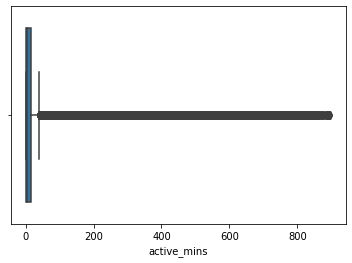

In [9]:
# We will further detect outliers in active minutes using IQR method.

# Lets plot the data first
sns.boxplot(t1am['active_mins'])
# As we can see there are large number of outliers present (black dots)

In [116]:
# Using IQR (interquartile range) method, we remove values that are less then lower quartile and more 
# than upper quartile.
# The IQR is used to measure how spread out the data points in a set are from the mean of the data set. 

Q1 = t1am['active_mins'].quantile(0.25)
Q3 = t1am['active_mins'].quantile(0.75)
IQR = Q3 - Q1
print(len(t1am[((t1am.active_mins) <  Q1 - 1.5*IQR)]))
print(len(t1am[((t1am.active_mins) > Q3 + 1.5*IQR)]))

t1am = t1am[((t1am.active_mins) >=  Q1 - 1.5*IQR)]
t1am = t1am[((t1am.active_mins) <= Q3 + 1.5*IQR)]
t1am.shape

0
41834


(809790, 3)

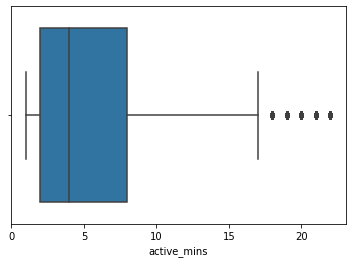

In [15]:
sns.boxplot(t1am['active_mins'])
# The values seem much more reasonable

In [25]:
# We will merge both t1 and t2 where uid is common
merged_table = pd.merge(left=t1am,right=t2uv, left_on='uid', right_on='uid', how='inner')

In [26]:
merged_table.head()

,uid,dt_x,active_mins,variant_number,dt_y,signup_date
0,0,2019-02-22,5.0,0,2019-02-06,2018-09-24
1,0,2019-03-11,5.0,0,2019-02-06,2018-09-24
2,0,2019-03-18,3.0,0,2019-02-06,2018-09-24
3,0,2019-03-22,4.0,0,2019-02-06,2018-09-24
4,0,2019-04-03,9.0,0,2019-02-06,2018-09-24


In [31]:
# row in each group
merged_table["variant_number"].value_counts()
# We can see control group has 712448 users and treatment group has 139176 users

0    712448
1    139176
Name: variant_number, dtype: int64

In [35]:
# We will group by user to compute mean time across all the visits
df_compare = merged_table.groupby(['uid','variant_number'], as_index = False)['active_mins'].mean()
df_compare.variant_number.value_counts()
# We can see control group has 37372 users and treatment group has 9172 users

0    37372
1     9172
Name: variant_number, dtype: int64

### Computing the Hypothesis Test

We will use hypothesis testing to compute the difference between treatment group and the control group. We use the Welch test, because its a two-sample t-test with unequal variance and is used to test the hypothesis that two populations have equal means

In [5]:
# Unpaired 2 sample-t-test also known as Welch Test with unequal variance
# It is assumed that variance is uneven
def welch_ttest(x1, x2,alternative_hypothesis):
    
    n1 = x1.size # sample size
    n2 = x2.size
    m1 = np.mean(x1) # mean
    m2 = np.mean(x2)
    delta = m1-m2
    
    v1 = np.var(x1, ddof=1) #variance
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2) # pooled standard error
    
    
    tstat = delta/pooled_se
    df = (v1/n1 + v2/n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two sided independent t-test
    p = 2*t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lowerb = delta - t.ppf(0.975,df)*pooled_se 
    upperb = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([df,tstat,p,delta,lowerb,upperb]).reshape(1,-1),
                         columns=['df','T statistic','pvalue-2-sided','Difference in mean',
                                  'lower_bound','upper_bound'])


In [83]:
control = df_compare[df_compare.variant_number == 0].active_mins
treatment = df_compare[df_compare.variant_number == 1].active_mins
welch_ttest(treatment, control, "equal")

,df,T statistic,pvalue-2-sided,Difference in mean,lower_bound,upper_bound
0,14265.407186,39.089502,0.0,1.231513,1.169759,1.293267


Since p-value < 0, we fail to reject the null hypothesis and conclude there is significant difference between the control and treatment group.

In [97]:
df_compare.groupby('variant_number', as_index=False)['active_mins'].mean()

,variant_number,active_mins
0,0,4.384977
1,1,5.616490


In [105]:
control.var()
treatment.var()

7.590691748264707

##### Q2. Include the logged minutes before test dataset, do you believe there is improvement between the control group (before the test dataset) and the treatment group (after the test dataset)? How does the pre-experiment data change your conclusion about the treatment effect on the experiment

In [69]:
# We know this table contains active minutes data before the experiment started.
t3am = pd.read_csv("t3_user_active_min_pre.csv")
t3am.head()
t3am.info()
# There are no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190093 entries, 0 to 1190092
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   uid          1190093 non-null  int64  
 1   dt           1190093 non-null  object 
 2   active_mins  1190093 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 27.2+ MB


In [71]:
# Remove all values that are beyond 1440 minutes
len(t3am[(t3am["active_mins"] > 1440)]) # Removed 160 rows
t3am = t3am[(t3am["active_mins"] <= 1440)]
t3am.shape

(1189927, 3)

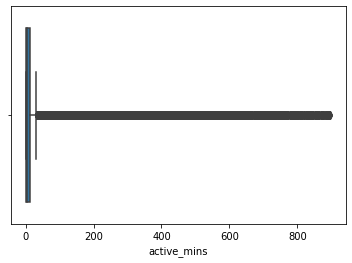

In [72]:
# Lets plot the data first
sns.boxplot(t3am['active_mins']) 
# We see a large number of outliers present 

In [117]:
Q1 = t3am['active_mins'].quantile(0.25)
Q3 = t3am['active_mins'].quantile(0.75)
IQR = Q3 - Q1

print(len(t3am[((t3am.active_mins) <  Q1 - 1.5*IQR)]))
print(len(t3am[((t3am.active_mins) > Q3 + 1.5*IQR)]))

t3am = t3am[((t3am.active_mins) >=  Q1 - 1.5*IQR)]
t3am = t3am[((t3am.active_mins) <= Q3 + 1.5*IQR)]
t3am.shape

0
98546


(930219, 3)

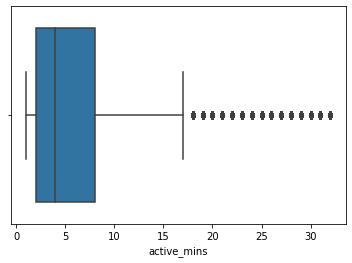

In [74]:
sns.boxplot(t3am['active_mins'])

#### Conducting unpaired sample t-test (Welch Test)


In [77]:
# First we will merge table 2 with table 3 to get which users are in control and treatment group
merged_table_2 = pd.merge(left=t3am,right=t2uv, left_on='uid', right_on='uid', how="inner")
merged_table_2.head()

,uid,dt_x,active_mins,variant_number,dt_y,signup_date
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24


In [79]:
merged_table_2["variant_number"].value_counts()
# We will group by user to compute mean time across all the visits for users before the experiment began
df_compare_2 = merged_table_2.groupby(['uid','variant_number'], as_index = False)['active_mins'].mean()
df_compare_2.variant_number.value_counts()
# We can see control group has 39734 users and treatment group has 9910 users

0    39734
1     9910
Name: variant_number, dtype: int64

In [ ]:
# We cannot do a paired sample t-test since the users aren't the same for before and after experiment.
# We use the control group before experimentation starts and compare that with the treatment group after experimentation
# starts
# We will use the indepedent/unpaired sample t-test with unequal variance

In [122]:
mu_before = df_compare[df_compare.variant_number==0]['active_mins']
mu_after = df_compare_2[df_compare_2.variant_number==1]['active_mins']

In [124]:
welch_ttest(mu_after, mu_before, "equal")

,df,T statistic,pvalue-2-sided,Difference in mean,lower_bound,upper_bound
0,13638.365042,11.830363,3.904822e-32,0.433627,0.361781,0.505474


Since p-value < 0, we reject the null hypothesis and conclude that there is significant difference between the treatment group (post-test) and the control group (pre-test). Since the mean of active minutes is higher under the treatment group, we can conclude that the treatment does improve the user engagament.

##### Q3. Include the attributes dataset, do you believe there is improvement between the control group (before the test dataset) and the treatment group (after the test dataset) based on different user attributes?

In [129]:
t4ua = pd.read_csv("t4_user_attributes.csv")
t4ua.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


In [131]:
#We will look into the treatment effect of different covariates of gender and user_type along with their interaction
table5 = pd.merge(left=t4ua,right=t2uv, left_on='uid', right_on='uid', how= "inner")
table5.head()

,uid,gender,user_type,variant_number,dt,signup_date
0,0,male,non_reader,0,2019-02-06,2018-09-24
1,1,male,reader,0,2019-02-06,2016-11-07
2,2,male,non_reader,0,2019-02-06,2018-09-17
3,3,male,non_reader,0,2019-02-06,2018-03-04
4,4,male,non_reader,0,2019-02-06,2017-03-09


In [132]:
# Looking at the user type
pd.crosstab(table5['variant_number'],table5['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
variant_number,,,,
0,0.022875,0.091325,0.717475,0.168325
1,0.012900,0.123500,0.736700,0.126900


In [133]:
# Looking at the gender type
pd.crosstab(table5['variant_number'],table5['gender']).apply(lambda r: r/r.sum(), axis=1)

gender,female,male,unknown
variant_number,,,
0,0.290175,0.555925,0.1539
1,0.287000,0.552000,0.1610


In [134]:
# Looking at interaction
pd.crosstab(table5['gender'],table5['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
gender,,,,
female,0.017200,0.109898,0.723907,0.148995
male,0.024462,0.083619,0.716108,0.175812
unknown,0.014937,0.125676,0.735127,0.124260


In [135]:
# We will further join this table with table 2 which has control and treatment
merged_final = pd.merge(left=t1am,right=table5, left_on='uid', right_on='uid')
merged_final.head()

,uid,dt_x,active_mins,gender,user_type,variant_number,dt_y,signup_date
0,0,2019-02-22,5.0,male,non_reader,0,2019-02-06,2018-09-24
1,0,2019-03-11,5.0,male,non_reader,0,2019-02-06,2018-09-24
2,0,2019-03-18,3.0,male,non_reader,0,2019-02-06,2018-09-24
3,0,2019-03-22,4.0,male,non_reader,0,2019-02-06,2018-09-24
4,0,2019-04-03,9.0,male,non_reader,0,2019-02-06,2018-09-24


### This is an important graphic

In [138]:
df_final = merged_final.groupby(['uid','variant_number','gender','user_type'], as_index=False)['active_mins'].mean()
df_final.head(20)

,uid,variant_number,gender,user_type,active_mins
0,0,0,male,non_reader,3.307692
1,1,0,male,reader,9.000000
2,2,0,male,non_reader,2.428571
3,3,0,male,non_reader,3.208333
4,4,0,male,non_reader,1.950000
5,5,0,female,non_reader,9.000000
6,6,0,female,non_reader,2.000000
7,7,0,male,non_reader,3.000000
8,9,0,female,non_reader,3.000000
9,10,0,male,non_reader,4.096774


In [139]:
df_final.to_csv('df_quora.csv')

#### We will calculate the confidence interval for each user type using the unpaired sample t-test

In [160]:

desciptive_stats = df_final.groupby(['variant_number','user_type'])['active_mins'].agg(['mean', 'count', 'std','var']).reset_index()
    
def welch_ttest_usertype(stats,usrtype):
    x1 = stats[(stats.variant_number==0) & (stats.user_type==usrtype)]
    x2 = stats[(stats.variant_number==1) & (stats.user_type==usrtype)]
    
    n1 = x1.iloc[0]['count']
    n2 = x2.iloc[0]['count']
    m1 = x1.iloc[0]['mean']
    m2 = x2.iloc[0]['mean']
    v1 = x1.iloc[0]['var']
    v2 = x2.iloc[0]['var']
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2) # pooled standard error
    delta = m1-m2
    
    tstat = delta/pooled_se
    df = (v1/n1 + v2/n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # upper and lower bounds
    lowerb = delta - t.ppf(0.975,df)*pooled_se 
    upperb = delta + t.ppf(0.975,df)*pooled_se
  
    return (lowerb, upperb)

(-0.4025475610198284, 0.4571292621233723)

In [161]:
ustypes = desciptive_stats['user_type'].unique()
ustypes = ustypes.tolist()
ustypes

['contributor', 'new_user', 'non_reader', 'reader']

In [163]:
for i in ustypes:
    interval = welch_ttest_usertype(desciptive_stats,i)
    print(i, ':', interval)

contributor : (-0.4025475610198284, 0.4571292621233723)
new_user : (-1.6139312215979746, -1.253031952000315)
non_reader : (-1.3799518113388707, -1.2854616371212881)
reader : (-0.7787305259690616, -0.5361562817457148)


**We can see that the contributor user type is non significant difference since 0 is in the interval. The rest of the user type are all significant. This indicates that there is significant difference between the control group and the treatment group for user type new_user, non_reader and reader.**

#### We will calculate the confidence interval for each gender using the unpaired sample t-test

In [167]:

desciptive_stats2 = df_final.groupby(['variant_number','gender'])['active_mins'].agg(['mean', 'count', 'std','var']).reset_index()

def welch_ttest_gender(stats,gendr):
    x1 = stats[(stats.variant_number==0) & (stats.gender==gendr)]
    x2 = stats[(stats.variant_number==1) & (stats.gender==gendr)]
    
    n1 = x1.iloc[0]['count']
    n2 = x2.iloc[0]['count']
    m1 = x1.iloc[0]['mean']
    m2 = x2.iloc[0]['mean']
    v1 = x1.iloc[0]['var']
    v2 = x2.iloc[0]['var']
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2) # pooled standard error
    delta = m1-m2
    
    tstat = delta/pooled_se
    df = (v1/n1 + v2/n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # upper and lower bounds
    lowerb = delta - t.ppf(0.975,df)*pooled_se 
    upperb = delta + t.ppf(0.975,df)*pooled_se
  
    return (lowerb, upperb)


In [169]:
genders = desciptive_stats2['gender'].unique()
genders = genders.tolist()
genders

['female', 'male', 'unknown']

In [170]:
desciptive_stats2

,variant_number,gender,mean,count,std,var
0,0,female,3.813892,10722,2.097881,4.401107
1,0,male,4.135381,20951,2.232407,4.983642
2,0,unknown,3.741863,5675,2.044282,4.179090
3,1,female,4.894670,2597,2.160392,4.667294
4,1,male,5.142351,5110,2.077629,4.316544
5,1,unknown,4.913884,1451,2.109469,4.449861


In [171]:
for i in genders:
    interval = welch_ttest_gender(desciptive_stats2,i)
    print(i, ':', interval)

female : (-1.172897611484917, -0.988659196716864)
male : (-1.0714680545110076, -0.9424723711896545)
unknown : (-1.2929575326716525, -1.051083330602728)


All the gender types are significant.

#### We will calculate the confidence interval for gender and user type using the unpaired sample t-test

In [181]:
desciptive_stats3 = df_final.groupby(['variant_number','gender','user_type'])['active_mins'].agg(['mean', 'count', 'std','var']).reset_index()

In [174]:
# Getting the covariates title
covariates = [(g,t) for g in genders for t in ustypes]
covariates

[('female', 'contributor'),
 ('female', 'new_user'),
 ('female', 'non_reader'),
 ('female', 'reader'),
 ('male', 'contributor'),
 ('male', 'new_user'),
 ('male', 'non_reader'),
 ('male', 'reader'),
 ('unknown', 'contributor'),
 ('unknown', 'new_user'),
 ('unknown', 'non_reader'),
 ('unknown', 'reader')]

In [184]:
desciptive_stats3

,variant_number,gender,user_type,mean,count,std,var
0,0,female,contributor,6.671780,220,2.419065,5.851874
1,0,female,new_user,2.769714,761,1.642570,2.698035
2,0,female,non_reader,3.297046,7935,1.596556,2.548991
3,0,female,reader,6.176604,1806,2.208072,4.875583
4,0,male,contributor,7.739456,567,2.547987,6.492238
5,0,male,new_user,2.931759,1132,1.798486,3.234553
6,0,male,non_reader,3.449876,15174,1.540658,2.373626
7,0,male,reader,6.519109,4078,2.309832,5.335323
8,0,unknown,contributor,6.896612,92,2.690255,7.237472
9,0,unknown,new_user,2.811588,477,1.763829,3.111094


In [176]:
def welch_ttest_interaction(stats,cov):
    x1 = stats[(stats.variant_number==0) & (stats.gender==cov[0]) & (stats.user_type==cov[1])]
    x2 = stats[(stats.variant_number==1) & (stats.gender==cov[0]) & (stats.user_type==cov[1])]
    
    n1 = x1.iloc[0]['count']
    n2 = x2.iloc[0]['count']
    m1 = x1.iloc[0]['mean']
    m2 = x2.iloc[0]['mean']
    v1 = x1.iloc[0]['var']
    v2 = x2.iloc[0]['var']
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2) # pooled standard error
    delta = m1-m2
    
    tstat = delta/pooled_se
    df = (v1/n1 + v2/n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # upper and lower bounds
    lowerb = delta - t.ppf(0.975,df)*pooled_se 
    upperb = delta + t.ppf(0.975,df)*pooled_se
  
    return (lowerb, upperb)

In [183]:
for c in covariates:
    interval = welch_ttest_interaction(desciptive_stats3,c)
    print(c, ':', interval)

('female', 'contributor') : (-1.4188755041551064, 0.20492997380720845)
('female', 'new_user') : (-1.8483884920728766, -1.218649942473176)
('female', 'non_reader') : (-1.4036774044936078, -1.2175834537955523)
('female', 'reader') : (-0.953328666398302, -0.49668879536118804)
('male', 'contributor') : (-0.40615328317995847, 0.7171353596485047)
('male', 'new_user') : (-1.5559926009919853, -1.0438769427219428)
('male', 'non_reader') : (-1.4100678936059106, -1.2870615142765873)
('male', 'reader') : (-0.7822805175384289, -0.4696335672046665)
('unknown', 'contributor') : (-0.7615205512858565, 1.5175542272446179)
('unknown', 'new_user') : (-2.0218786869192367, -1.1578650103203938)
('unknown', 'non_reader') : (-1.427412790777369, -1.1891673584564908)
('unknown', 'reader') : (-1.051594824596254, -0.3493854613089073)


We can see that female contributor, male contributor and unknown contributor are not significant while the rest of them are.

In [ ]:
## The data visualization was done in R using GGplot

# Code for user type plot

# library(readr)
# library(ggplot2)
# df <- read_csv("quora.csv")
# g <- ggplot(df, aes(user_type, active_mins))
# g + geom_boxplot(aes(fill=factor(variant_number)))+
# theme(
# panel.background = element_blank(),
# panel.grid.major = element_line(colour = "blue",size=0.01,linetype =
# 8),
# panel.grid.minor = element_blank(),
# axis.line.x = element_line(colour = "black"),
# axis.line.y = element_line(colour = "black"),
# legend.background = element_rect(fill="transparent", size=0.5,linetype="solid"),
# legend.position = c(0.8,0.9),
# legend.text = element_text(colour="black", size=14),
# strip.text.x = element_text(size = 14)) + labs(x='User Type', y='Active Mins') + 
# guides(fill=guide_legend(title="Treatment")) + ggtitle("Fig 1a: Box plot of active minutes 
# between control and treatment based on user type")

# ```{r, echo=FALSE}

# gender Plot

# g <- ggplot(df, aes(gender, active_mins))
# g + geom_boxplot(aes(fill=factor(variant_number)))+
# theme(
# panel.background = element_blank(),
# panel.grid.major = element_line(colour = "grey",size=0.01,linetype = 8),
# panel.grid.minor = element_blank(),
# legend.title=element_text(size=14),
# legend.box = "horizontal",
# axis.text = element_text(colour = "black"),
# axis.text.x = element_text(size = 14,vjust=0.6),
# strip.text.x = element_text(size = 14)) + guides(fill=guide_legend(title="Treatment")) + 
# ggtitle("Fig 1b: Box plot of active minutes between control and treatment based on gender")
# + labs(x='User-Gender',y='Active Mins')

# # Interaction plot

# df$int <- interaction(df$user_type, df$gender)
# g <- ggplot(df3, aes(int, active_mins))
# g + geom_boxplot(aes(fill=factor(variant_number)))+
# theme(
# panel.background = element_blank(),
# panel.grid.major = element_line(colour = "grey",size=0.01,linetype = 8),
# panel.grid.minor = element_blank(),
# axis.line.x = element_line(colour = "black"),
# axis.line.y = element_line(colour = "black"),
# legend.background = element_rect(fill="transparent", size=0.5,
# linetype="solid"),
# legend.text = element_text(colour="black", size=14),
# legend.title=element_text(size=14),
# legend.box = "horizontal",
# strip.text.x = element_text(size = 14)) + labs(x='User_Type - Gender',y='Active Mins') + 
# guides(fill=guide_legend(title="Treatment")) + ggtitle("Fig 2: Box plot of active minutes 
# between control and treatment based on\n interaction of user type and gender")
# ```